In [18]:
# https://github.com/pytorch/vision/blob/master/torchvision/ops/roi_pool.py
import torch
from torch import nn, Tensor
from torch.nn.modules.utils import _pair
from torch.jit.annotations import List, BroadcastingList2

def _cat(tensors, dim=0):
    # type: (List[Tensor], int) -> Tensor
    """
    Efficient version of torch.cat that avoids a copy if there is only a single element in a list
    """
    # TODO add back the assert
    # assert isinstance(tensors, (list, tuple))
    if len(tensors) == 1:
        return tensors[0]
    return torch.cat(tensors, dim)

def convert_boxes_to_roi_format(boxes):
    # type: (List[Tensor]) -> Tensor
    concat_boxes = _cat([b for b in boxes], dim=0)
    temp = []
    for i, b in enumerate(boxes):
        temp.append(torch.full_like(b[:, :1], i))
    ids = _cat(temp, dim=0)
    rois = torch.cat([ids, concat_boxes], dim=1)
    return rois

def roi_pool(input, boxes, output_size, spatial_scale=1.0):
    # type: (Tensor, Tensor, BroadcastingList2[int], float) -> Tensor
    """
    Performs Region of Interest (RoI) Pool operator described in Fast R-CNN
    Arguments:
        input (Tensor[N, C, H, W]): input tensor
        boxes (Tensor[K, 5] or List[Tensor[L, 4]]): the box coordinates in (x1, y1, x2, y2)
            format where the regions will be taken from. If a single Tensor is passed,
            then the first column should contain the batch index. If a list of Tensors
            is passed, then each Tensor will correspond to the boxes for an element i
            in a batch
        output_size (int or Tuple[int, int]): the size of the output after the cropping
            is performed, as (height, width)
        spatial_scale (float): a scaling factor that maps the input coordinates to
            the box coordinates. Default: 1.0
    Returns:
        output (Tensor[K, C, output_size[0], output_size[1]])
    """
    rois = boxes
    output_size = _pair(output_size)
    if not isinstance(rois, torch.Tensor):
        rois = convert_boxes_to_roi_format(rois)
    output, _ = torch.ops.torchvision.roi_pool(input, rois, spatial_scale, output_size[0], output_size[1])
    return output

class RoIPool(nn.Module):
    def __init__(self, output_size, spatial_scale):
        super(RoIPool, self).__init__()
        self.output_size = output_size
        self.spatial_scale = spatial_scale
    def forward(self, input, rois):
        return roi_pool(input, rois, self.output_size, self.spatial_scale)
    def __repr__(self):
        tmpstr = self.__class__.__name__ + '('
        tmpstr += 'output_size=' + str(self.output_size)
        tmpstr += ', spatial_scale=' + str(self.spatial_scale)
        tmpstr += ')'
        return tmpstr

In [19]:
import torch
import torch.nn.functional as F
from SphereNet_PyTorch.spherenet import SphereConv2D, SphereMaxPool2D

class SphereNetVGG16(torch.nn.Module):
    def __init__(self):
        super(SphereNetVGG16, self).__init__()
        # conv_block_1
        self.conv1_1 = SphereConv2D(3 , 64, stride=1)
        self.conv1_2 = SphereConv2D(64, 64, stride=1)
        # conv_block_2
        self.conv2_1 = SphereConv2D(64 , 128, stride=1)
        self.conv2_2 = SphereConv2D(128, 128, stride=1)
        # conv_block_3
        self.conv3_1 = SphereConv2D(128, 256, stride=1)
        self.conv3_2 = SphereConv2D(256, 256, stride=1)
        self.conv3_3 = SphereConv2D(256, 256, stride=1)
        # conv_block_4
        self.conv4_1 = SphereConv2D(256, 512, stride=1)
        self.conv4_2 = SphereConv2D(512, 512, stride=1)
        self.conv4_3 = SphereConv2D(512, 512, stride=1)
        # conv_block_5
        self.conv5_1 = SphereConv2D(512, 512, stride=1)
        self.conv5_2 = SphereConv2D(512, 512, stride=1)
        self.conv5_3 = SphereConv2D(512, 512, stride=1)
        self.pool = SphereMaxPool2D(stride=2)
        
        # classification layers
        self.fc6 = nn.Linear(7*7*512, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 1000)
        
    # Pure VGG16
    def forward(self, image, input_roi):
        x = F.relu(self.conv1_2(F.relu(self.conv1_1(image))))
        x = self.pool(x)
        x = F.relu(self.conv2_2(F.relu(self.conv2_1(x))))
        x = self.pool(x)
        x = F.relu(self.conv3_3(F.relu(self.conv3_2(F.relu(self.conv3_1(x))))))
        x = self.pool(x)
        x = F.relu(self.conv4_3(F.relu(self.conv4_2(F.relu(self.conv4_1(x))))))
        x = self.pool(x)
        x = F.relu(self.conv5_3(F.relu(self.conv5_2(F.relu(self.conv5_1(x))))))
        
        #x = self.pool(x)
        x = RoIPool(output_size=7, spatial_scale=1)(x, input_roi)
        x = x.view(-1, 7 * 7 * 512)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, SphereConv2D):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    # https://github.com/hadikazemi/Machine-Learning/blob/master/PyTorch/tutorial/vgg16.py
    def predict(self, x):
        # a function to predict the labels of a batch of inputs
        x = F.softmax(self.forward(x, training=False))
        return x

torch.Size([1, 3, 128, 256])


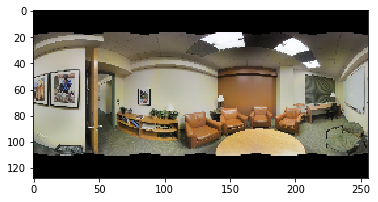

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms.functional as tfun

device = torch.device('cpu')
spheremodel = SphereNetVGG16().to(device)

path = 'C:/Users/ustundag/Desktop/test_pano_rgb.png'
img = Image.open(path)
img = img.resize((256, 128))
data = np.asarray(img, dtype=np.float32)
data = tfun.to_tensor(data)
data = data.unsqueeze_(0)
data = data[:,:3,:,:]
print(data.shape)
plt.imshow(img)
plt.show()

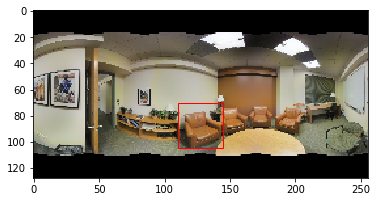

In [21]:
from matplotlib.patches import Rectangle

fig,ax = plt.subplots(1)
ax.imshow(img)
rect = Rectangle((110,70),35,35,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [24]:
num_rois=1
rois = np.zeros((num_rois, 4))
rois[0] = [110, 105, 145, 70]
print(rois.shape)

rois = torch.FloatTensor([[0, 110, 105, 145, 70]])

#rois = tfun.to_tensor(rois)

preds = spheremodel(data.to(device), rois.to(device))
print(preds.shape)


(1, 4)


RuntimeError: No such operator torchvision::roi_pool

In [ ]:
""" ////////////////////////////////////////// """
""" ////////////////////////////////////////// """
""" ////////////////////////////////////////// """
""" ////////////////////////////////////////// """
""" ////////////////////////////////////////// """
""" ////////////////////////////////////////// """
""" ////////////////////////////////////////// """
""" ////////////////////////////////////////// """
""" ////////////////////////////////////////// """


In [ ]:
import torchvision.models as models
vgg16 = models.vgg16()

device = torch.device('cpu')
spheremodel = SphereNetVGG16().to(device)

In [ ]:
# Retrieve SphereNet model state
sphere_dict = spheremodel.state_dict()
"""
"""
for k, v in sphere_dict.items():
    print(k,'-',v[0,0,0,0])
    break

In [ ]:
# Load pre-trained VGG16 model state
#vgg16_dict = torch.load('C:/Users/ustundag/.cache/torch/checkpoints/vgg16-397923af.pth')
vgg16_dict = vgg16.state_dict()

# Cut out the classifier layers at the end
vgg16_dict = {k: vgg16_dict[k] for k in vgg16_dict.keys() if 'classifier' not in k}

# Assign VGG16 weights to the layers of SphereNet
for (k_sph,v_sph), (k_vgg,v_vgg) in zip(sphere_dict.items(), vgg16_dict.items()):
    sphere_dict[k_sph] = v_vgg

""""""
for k, v in sphere_dict.items():
    print(k,'-',v[0,0,0,0])
    break


In [ ]:
''' ---------------------------------------------------- '''

In [ ]:
spheremodel.load_state_dict(sphere_dict)
fmap = spheremodel(data.to(device))
#fmap = fmap.reshape(fmap.shape[0], fmap.shape[1], fmap.shape[2]*fmap.shape[3])
print(fmap.shape)

fmap = fmap.detach().numpy()
plt.figure(figsize=(8, 8))
for i in range(2):
    plt.subplot(4, 1, i + 1)
    plt.imshow(fmap[0,i,:,:])
plt.show()

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions
from keras import layers

f_map     = layers.Input(shape=(1, 14, 14, 512))
input_roi = layers.Input(shape=(1,4))

x = RoiPoolingConv(7, 1)([f_map, input_roi])
# Classification block
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='fc1')(x)
x = layers.Dense(4096, activation='relu', name='fc2')(x)
x = layers.Dense(1000, activation='softmax', name='predictions')(x)

model = Model([image, input_roi], x)
model.summary()

### Classify feature map using VGG16 classifier

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img

img_path = 'C:/Users/ustundag/Desktop/test_pano_rgb.png'
img   = load_img(img_path, target_size=(224, 448))
image = img_to_array(img)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
plt.imshow(img)
plt.show()

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.applications.imagenet_utils import decode_predictions

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=True)
DL_input = Input(vgg16.layers[19].input_shape[1:])
DL_model = DL_input
for layer in vgg16.layers[19:]:
    DL_model = layer(DL_model)
DL_model = Model(inputs=DL_input, outputs=DL_model)

DL_model.summary()

In [ ]:
xx = fmap
xx = xx.reshape(1, xx.shape[2], xx.shape[3], xx.shape[1])
xx = xx[:, 1:8, 9:16, :]
xx.shape

In [ ]:
print("[INFO] classifying image with VGG16...")
preds = DL_model.predict(xx)
P = decode_predictions(preds)

# loop over the predictions and display the rank-5 predictions
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

In [ ]:
import os
import tarfile
import urllib
import urllib.request

# Download weights
if not os.path.isdir('weights'):
    os.makedirs('weights')
if not os.path.isfile('weights/vgg_16.ckpt'):
    print('Downloading the checkpoint ...')
    urllib.request.urlretrieve("http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz", "weights/vgg_16_2016_08_28.tar.gz")
    with tarfile.open('weights/vgg_16_2016_08_28.tar.gz', "r:gz") as tar:
        tar.extractall('weights/')
    os.remove('weights/vgg_16_2016_08_28.tar.gz')
    print('Download is complete !')